# MIS780 Advanced AI For Business - Assignment 2 - T2 2024

## Task Number: Gold price prediction - time series

**Student Name:** _Jeremiyah Mathew Peter_

**Student ID:** _222632529_

## Table of Content

1. [Executive Summary](#cell_Summary)

2. [Data Preprocessing](#cell_Preprocessing)

3. [Predictive Modeling](#cell_model)

4. [Experiments Report](#cell_report)



<a id = "cell_Summary"></a>
## 1. Executive Summary

Our aim was to build the best model which can predict the Gold price in USD using the data from 1985 till 2023 using different currencies.

We built the models and found the best model RNN 5 which has consistent low MAE values in all the horizons which means it is not prone to Over-fitting and when new real-world data is trained, it would provide more accurate results.

Hyperparameter tuning using grid search would help in model optimisation, More advanced architecture and early stopping when validation scores deteriorate would help in improving the model further for real world applications.

<a id = "cell_Preprocessing"></a>
## 2. Data Preprocessing

*Carry out necessary data preprocessing and exploration.*

In [1]:
# Importing the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.optimizers import SGD
from tensorflow.random import set_seed

set_seed(455)
np.random.seed(455)

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
Goldie = pd.read_csv('/content/drive/MyDrive/Part3_GoldPrice.csv', index_col='Date', parse_dates=["Date"],dayfirst=True)
print(Goldie.head())

               USD     EUR     GBP      INR      AED     CNY
Date                                                        
1985-01-07  298.25  392.55  261.17  3741.23  1091.58  835.80
1985-01-08  302.00  395.32  263.07  3820.70  1114.06  853.01
1985-01-09  300.50  393.54  263.14  3742.23  1097.47  840.31
1985-01-10  303.80  397.63  268.02  3853.39  1126.83  862.79
1985-01-11  304.25  398.60  270.57  3845.57  1135.85  869.69


In [7]:
print(Goldie.describe())

                USD           EUR           GBP            INR           AED  \
count  10110.000000  10110.000000  10110.000000   10110.000000  10110.000000   
mean     799.748447    670.104859    541.061313   43943.953027   2937.273903   
std      544.877305    463.238285    418.207087   43584.544951   2001.450645   
min      252.800000    222.200000    156.890000    3687.170000    928.480000   
25%      356.712500    307.275000    221.530000   11751.397500   1311.205000   
50%      440.625000    374.990000    265.350000   18312.495000   1618.690000   
75%     1270.500000   1064.012500    884.770000   79406.525000   4666.550000   
max     2067.150000   1863.680000   1634.970000  167324.360000   7592.640000   

                CNY  
count  10110.000000  
mean    5307.108772  
std     3659.619165  
min      809.630000  
25%     2220.950000  
50%     3376.265000  
75%     8326.245000  
max    14373.930000  


In [8]:
Goldie.isna().sum()

,0
USD,0
EUR,0
GBP,0
INR,0
AED,0
CNY,0


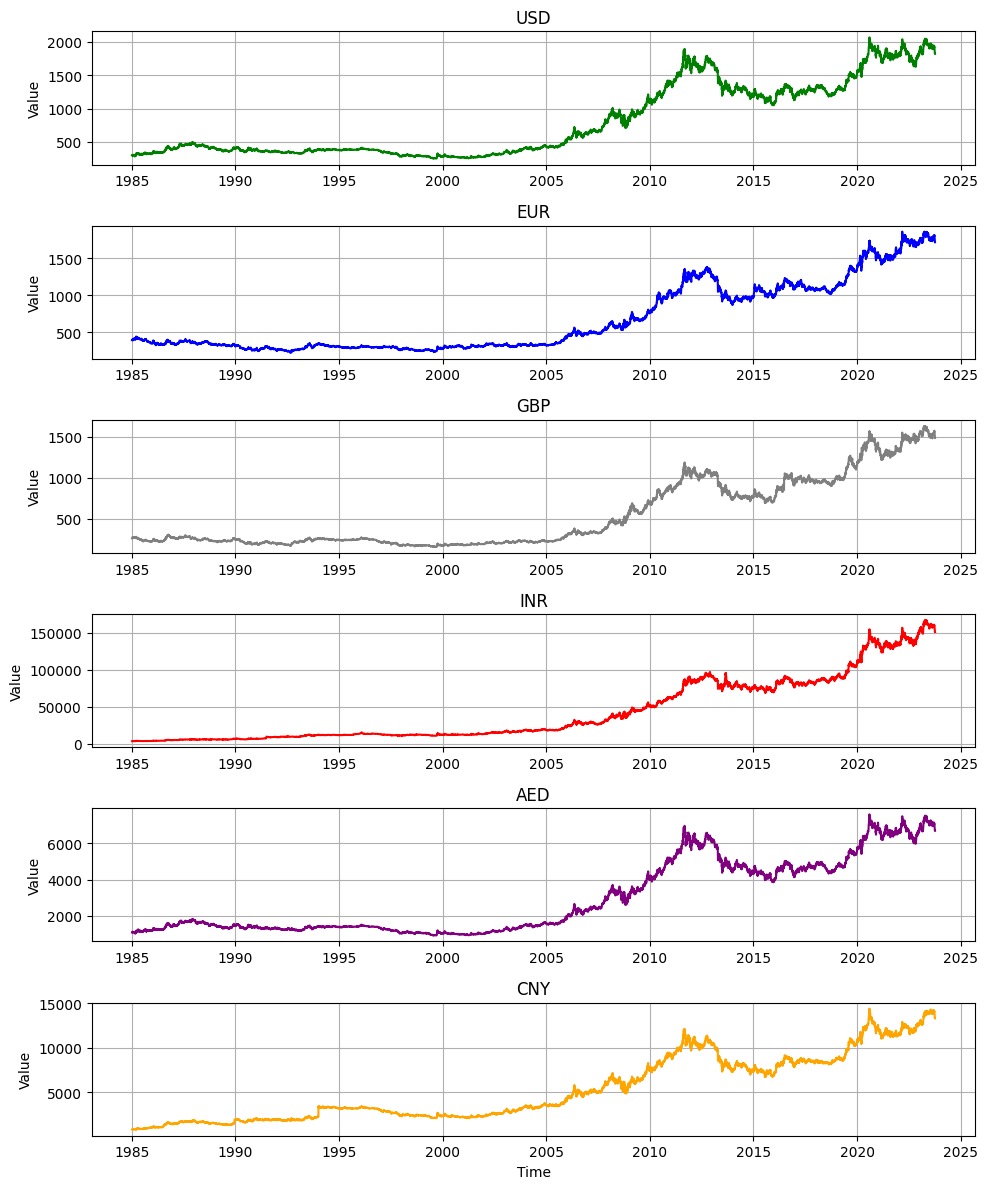

In [9]:
import matplotlib.pyplot as plt

# Define currencies and their respective colors
currencies = ['USD', 'EUR', 'GBP', 'INR', 'AED', 'CNY']
colors = ['green', 'blue', 'grey', 'red', 'purple', 'orange']

# Create subplots
fig, axs = plt.subplots(len(currencies), 1, figsize=(10, 12))

# Plot each currency in the respective subplot
for i, currency in enumerate(currencies):
    axs[i].plot(Goldie[currency], color=colors[i])
    axs[i].set_title(currency)
    axs[i].set_ylabel('Value')  # Optionally add y-axis label
    axs[i].grid(True)  # Optionally add a grid for clarity

# Add a common x-axis label
plt.xlabel('Time')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

In [10]:
import pandas as pd

# Assuming 'dataset' is already loaded and 'Date' is the index
def train_test_split(Goldie, tstart, tend):
    # Define the training and test sets based on the specified end date for training
    train = Goldie.loc[:f"{tend}-12-31"] # Changed train_end to tend
    test = Goldie.loc[f"{tend+1}-01-01":] # Changed train_end to tend

    return train, test

# Example usage
train_end = 2021  # End year for training
training_set, test_set = train_test_split(Goldie, 0, train_end) # Added 0 for tstart

# Optionally, print the split sets
print(f"Training set from {training_set.index.min()} to {training_set.index.max()}")
print(f"Test set from {test_set.index.min()} to {test_set.index.max()}")

Training set from 1985-01-07 00:00:00 to 2021-12-31 00:00:00
Test set from 2022-01-03 00:00:00 to 2023-10-06 00:00:00


In [11]:
training_set_shape = training_set.shape
test_set_shape = test_set.shape
print('training_set shape:', training_set_shape)
print('test_set shape:', test_set_shape)

training_set shape: (9650, 6)
test_set shape: (460, 6)


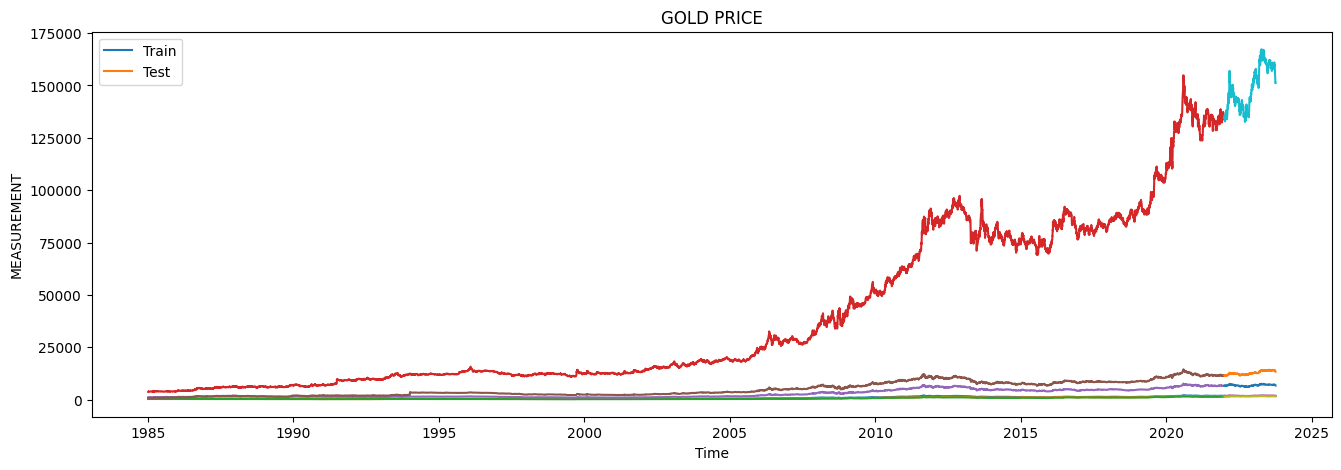

In [12]:
plt.figure(figsize=(16, 5))
plt.plot(training_set)
plt.plot(test_set)
plt.title('GOLD PRICE')
plt.ylabel('MEASUREMENT')
plt.xlabel('Time')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [13]:
mm = MinMaxScaler(feature_range=(0, 1))
training_set = training_set.values.reshape(-1, 1)
training_set_scaled = mm.fit_transform(training_set)
print('training_set_scaled shape after scaling:', training_set_scaled.shape)

training_set_scaled shape after scaling: (57900, 1)


In [14]:
training_set_scaled = training_set_scaled.reshape(training_set_shape[0], training_set_shape[1])
print('training_set_scaled shape:', training_set_scaled.shape)

training_set_scaled shape: (9650, 6)


In [15]:
def split_sequence(sequence, n_steps,forecasting_horizon, y_index):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence) - forecasting_horizon:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:end_ix+forecasting_horizon,y_index]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [16]:
n_steps = 80
forecasting_horizon = 14
n_features = 6
y_index = 1
# split into samples
X_train, y_train = split_sequence(training_set_scaled, n_steps,forecasting_horizon,y_index)

In [17]:
# Reshaping X_train for model
y_train  = y_train.reshape(y_train .shape[0],y_train.shape[1],1)

In [18]:
print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)

X_train shape: (9557, 80, 6)
y_train shape: (9557, 14, 1)


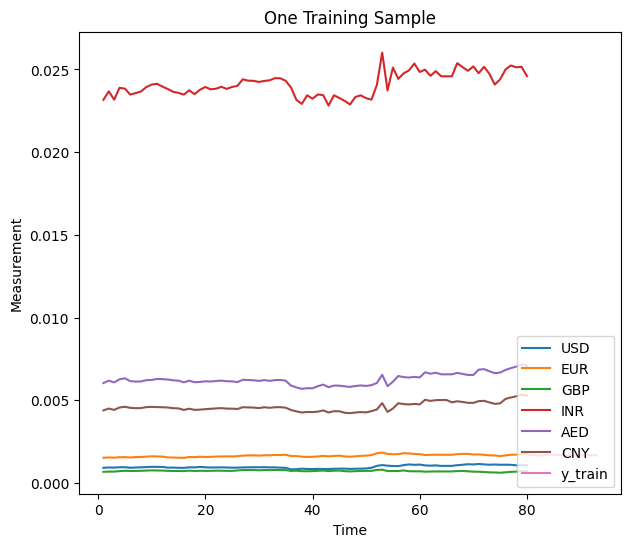

In [19]:
plt.figure(figsize=(7, 6))
plt.plot(np.arange(1, n_steps+1, 1),X_train[0,:,0])
plt.plot(np.arange(1, n_steps+1, 1),X_train[0,:,1])
plt.plot(np.arange(1, n_steps+1, 1),X_train[0,:,2])
plt.plot(np.arange(1, n_steps+1, 1),X_train[0,:,3])
plt.plot(np.arange(1, n_steps+1, 1),X_train[0,:,4])
plt.plot(np.arange(1, n_steps+1, 1),X_train[0,:,5])
plt.plot(np.arange(n_steps, n_steps+forecasting_horizon, 1),y_train[0])
plt.title('One Training Sample')
plt.ylabel('Measurement')
plt.xlabel('Time')
plt.legend(['USD','EUR','GBP','INR','AED','CNY', 'y_train'], loc='lower right')

<a id = "cell_model"></a>
## 3. Predictive Modeling

*Create and explain your models (e.g., model architecture, model parameters). Evaluate the models on the experimental data sets.*

In [21]:
from keras.layers import LSTM, Dropout, Dense, GRU

In [43]:
model_lstm = Sequential()
model_lstm.add(LSTM(units=100, activation="tanh", return_sequences=True, input_shape=(n_steps, n_features)))
model_lstm.add(Dropout(0.2))  # Dropout for regularization
model_lstm.add(LSTM(units=50, activation="tanh"))
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(units=30))
model_lstm.add(Dense(units=forecasting_horizon))
# Compiling the model
model_lstm.compile(optimizer="adam", loss="mse")

model_lstm.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_11 (LSTM)                       │ (None, 80, 100)             │          42,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 80, 100)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_12 (LSTM)                       │ (None, 50)                  │          30,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 30)                  │           1,530 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 14)                  │             434 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 74,964 (292.83 KB)

 Trainable params: 74,964 (292.83 KB)

 Non-trainable params: 0 (0.00 B)

In [44]:
model_lstm.fit(X_train, y_train, epochs=100, batch_size=32)

Epoch 1/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 6.4429e-05
Epoch 2/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 3.0531e-06
Epoch 3/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 1.6849e-06
Epoch 4/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 1.0575e-06
Epoch 5/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 8.1035e-07
Epoch 6/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 6.7208e-07
Epoch 7/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 5.2365e-07
Epoch 8/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 4.9220e-07
Epoch 9/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 4.5904e-07
Epoch 10/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 4.1136e-07
Epoch 11/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 3.9416e-07
Epoch 12/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 3.5084e-07
Epoch 13/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 3.0679e-07
Epoch 14/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step 

RNN Testing

In [45]:
#scaling
inputs = test_set.values.reshape(-1, 1)
inputs = mm.transform(inputs)
#Reshape back to orignal format after rescaling
inputs = inputs.reshape(test_set_shape[0], test_set_shape[1])

# Split into samples
X_test, y_test = split_sequence(inputs, n_steps,forecasting_horizon,y_index)
number_test_samples = X_test.shape[0]
print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)

X_test shape: (367, 80, 6)
y_test shape: (367, 14)


In [46]:
#prediction
predicted_Gold_price = model_lstm.predict(X_test)

#inverse transform the predicted values
predicted_Gold_price = mm.inverse_transform(predicted_Gold_price)
print('predicted_Gold_price shape: ', predicted_Gold_price.shape)

#inverse transform the test labels.
y_test = y_test.reshape(y_test.shape[0], y_test.shape[1])
y_test = mm.inverse_transform(y_test)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
predicted_Gold_price shape:  (367, 14)


In [47]:
def return_mae(test, predicted):
    mae = mean_absolute_error(test, predicted)
    print("Mean Absolute Error {:.2f}.".format(mae))

for i in range(forecasting_horizon):
  print("Forecasting Horizon: {} ".format(i))
  return_mae(y_test[:,i],predicted_Gold_price[:,i])
  print("")

Forecasting Horizon: 0 
Mean Absolute Error 21.38.

Forecasting Horizon: 1 
Mean Absolute Error 22.89.

Forecasting Horizon: 2 
Mean Absolute Error 24.18.

Forecasting Horizon: 3 
Mean Absolute Error 24.06.

Forecasting Horizon: 4 
Mean Absolute Error 24.62.

Forecasting Horizon: 5 
Mean Absolute Error 31.69.

Forecasting Horizon: 6 
Mean Absolute Error 28.48.

Forecasting Horizon: 7 
Mean Absolute Error 45.93.

Forecasting Horizon: 8 
Mean Absolute Error 28.34.

Forecasting Horizon: 9 
Mean Absolute Error 46.50.

Forecasting Horizon: 10 
Mean Absolute Error 48.57.

Forecasting Horizon: 11 
Mean Absolute Error 55.40.

Forecasting Horizon: 12 
Mean Absolute Error 32.30.

Forecasting Horizon: 13 
Mean Absolute Error 43.05.



In [49]:
X_test = X_test.reshape(-1, 80)
X_test = mm.inverse_transform(X_test)
X_test = X_test.reshape(number_test_samples, 80,6)

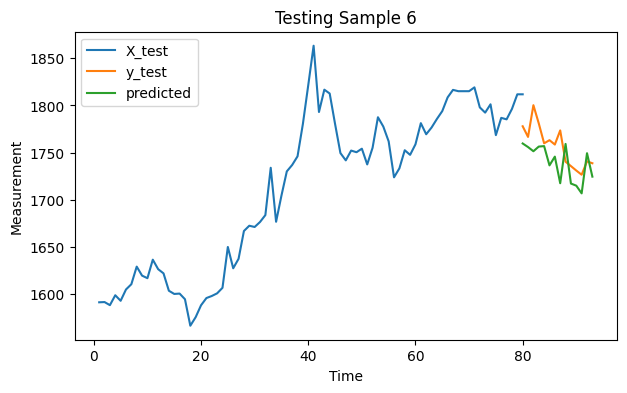

In [50]:
#Here we visualize the real vs. predicted values of the last testing segment.
sample_index = 6

plt.figure(figsize=(7, 4))
plt.plot(np.arange(1, n_steps+1, 1),X_test[sample_index,:,1])
plt.plot(np.arange(n_steps, n_steps+forecasting_horizon, 1),y_test[sample_index,:])
plt.plot(np.arange(n_steps, n_steps+forecasting_horizon, 1),predicted_Gold_price[sample_index,:])
plt.title('Testing Sample ' + str(sample_index))
plt.ylabel('Measurement')
plt.xlabel('Time')
plt.legend(['X_test', 'y_test', 'predicted'], loc='upper left')

In [51]:
def plot_predictions(test, predicted):
    plt.plot(test, color="gray", label="Real")
    plt.plot(predicted, color="red", label="Predicted")
    plt.title("Gold Price Prediction")
    plt.xlabel("Days Ahead")
    plt.ylabel("Gold Price")
    plt.legend()
    plt.show()

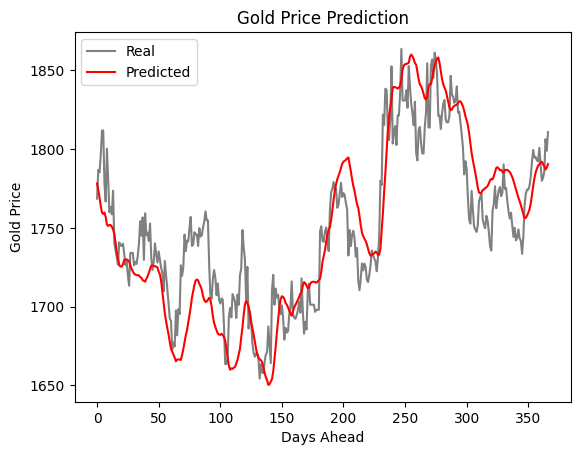

In [52]:
#Here we visualize the real vs. predicted values for one day forecasting horizon.
plot_predictions(y_test[:,0],predicted_Gold_price[:,0])

<a id = "cell_report"></a>
## 4. Experiments Report

zoom in to see the results

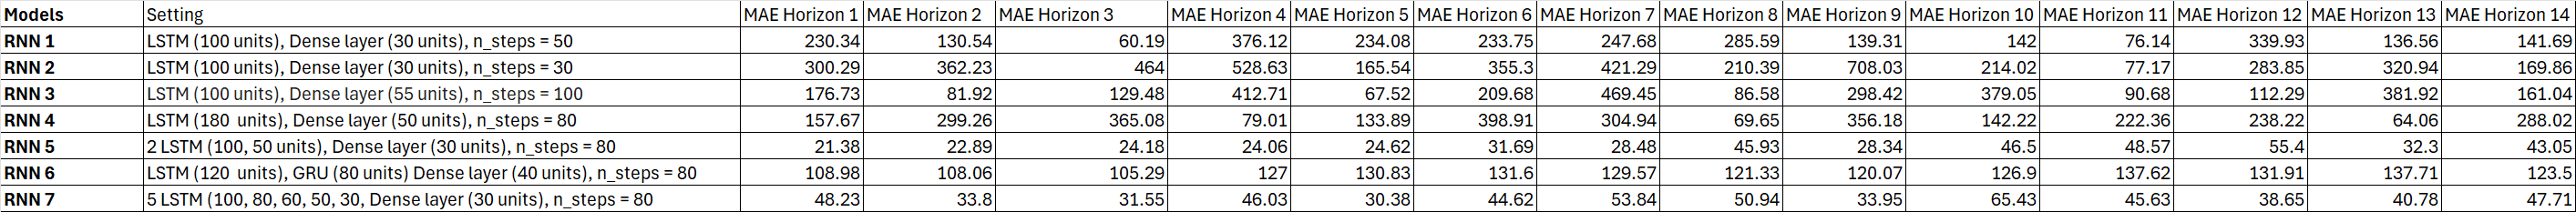

RNN 5 and RNN 7 have the lowest MAE values for forecasting horizons. However, as the best model, we choose **RNN 5** because of its consistent low MAE score across all horizons despite having just two LSTM layers. It shows that the model is not prone to over-fitting and the visualisations for actual and predicted values closely match in the case of RNN 5. Inconsistent MAE values for RNN 7 forecasting horizons means the model is prone to over-fitting because of its deeper architecture of 5 LSTM layers. Other models have high values for forecasting horizon MAEs.

**Justification**

The two layers of LSTM (100, 50 units) shows that the model is able to strike a balance between capturing complex patterns and avoiding over-fitting.
Regularisation with drop-out has also helped in reducing over-fitting.

Number of steps (80) was long enough to capture important time dependencies without overwhelming the model. It disregarded irrelevant data and took in important information.

**How to improve the model for real-world scenarios**

The RNN 5 is a good model for real-world scenarios as the MAE scores are consistent for all horizons. It would avoid overfitting.

However, There are certain ways to improve:

1. hyperparameter tuning: Using grid search to find the optimal value for number of steps, LSTM units and learning rate.

2. Advanced architecture: Architectures like Bi-directional LSTMs, hybrid models like CNN-LSTM can be used.

3. Early stopping: Early stopping can be used to prevent over-fitting when validation performance starts to degrade.